### Kondo resonance
This notebook takes 1700s in Analytic continuation.  
The broaden parameter $\eta$ is chosen to be smaller than all energy scales of the system.  
To try this notebook, please install the fllowing package
- Plots
- LaTexStrings
- SparseIR

In [1]:
#load package
using Plots
using LaTeXStrings
using LinearAlgebra
using SparseIR
using Nevanlinna

In [2]:
# Set work data Type
T = BigFloat
setprecision(128)
;

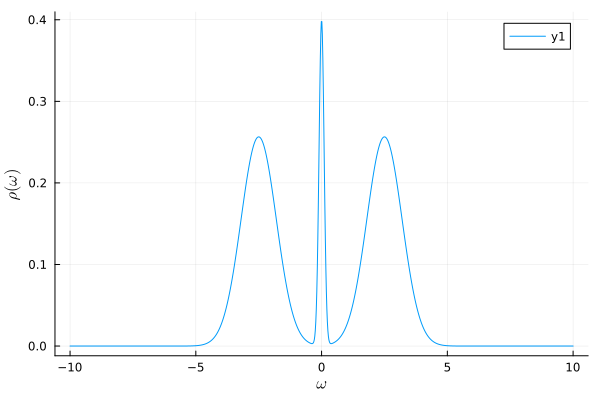

In [3]:
#define spectral function
gaussian(x, mu, sigma) = exp(-0.5*((x-mu)/sigma)^2)/(sqrt(2*π)*sigma)
rho(omega) = 0.45*gaussian(omega, -2.5, 0.7) + 0.1*gaussian(omega, 0.0, 0.1) + 0.45*gaussian(omega, 2.5, 0.7)
omegas = LinRange(-10, 10, 1000)
plot()
plot!(omegas, rho.(omegas), xlabel=latexstring("\\omega"), ylabel=latexstring("\\rho(\\omega)"))

In [4]:
function generate_input_data(rho::Function, beta::Float64)
    lambda = 1e+4
    wmax = lambda/beta
    basis = FiniteTempBasisSet(beta, wmax, 1e-15)

    rhol = [overlap(basis.basis_f.v[l], rho) for l in 1:length(basis.basis_f)]
    gl = - basis.basis_f.s .* rhol
    gw = evaluate(basis.smpl_wn_f, gl)
    
    hnw = length(basis.smpl_wn_f.sampling_points)÷2
    
    input_smpl = Array{Complex{T}}(undef, hnw) 
    input_gw   = Array{Complex{T}}(undef, hnw) 
    
    for i in 1:hnw
        input_smpl[i]= SparseIR.valueim(basis.smpl_wn_f.sampling_points[hnw+i], beta)
        input_gw[i]  = gw[hnw+i]
    end
    
    return input_smpl, input_gw
end

generate_input_data (generic function with 1 method)

In [5]:
beta = 100. #inverse temperature
input_smpl, input_gw = generate_input_data(rho, beta)
;

In [6]:
N_real    = 1000  #demension of array of output
omega_max = 10.0  #energy cutoff of real axis
eta       = 0.001 #broaden parameter 
sum_rule  = 1.0   #sum rule
H_max     = 50    #cutoff of Hardy basis
lambda    = 1e-4  #regularization parameter
iter_tol  = 1000  #upper bound of iteration
;

In [7]:
#construct solver struct
@time sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=false)
;

197.584043 seconds (4.02 G allocations: 170.515 GiB, 15.73% gc time, 8.73% compilation time)


In [8]:
#execute optimize
@time Nevanlinna.solve!(sol)
;

1491.584048 seconds (23.71 G allocations: 993.340 GiB, 21.39% gc time, 0.00% compilation time: 100% of which was recompilation)


In [9]:
wo_sol = Nevanlinna.NevanlinnaSolver(input_smpl, input_gw, N_real, omega_max, eta, sum_rule, H_max, iter_tol, lambda, verbose=false, optimization=false)
;

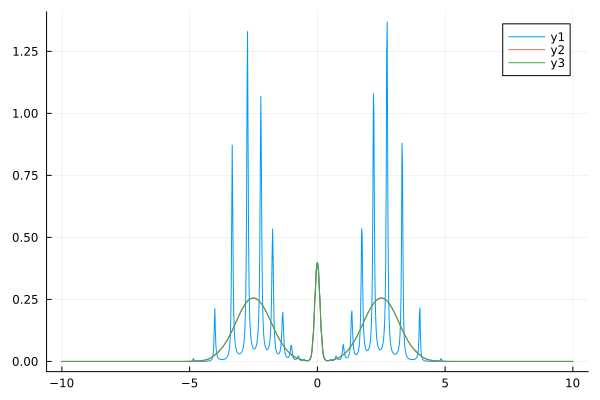

In [10]:
plot()
plot!(real.(wo_sol.reals.freq), imag.(wo_sol.reals.val)/pi)
plot!(Float64.(real.((sol.reals.freq))), Float64.(imag.(sol.reals.val))/pi)
plot!(omegas, rho.(omegas))

In [11]:
open("data/kondo_wo_opt.dat","w") do f
    for i in 1:wo_sol.reals.N_real
        println(f, "$(Float64(real.(wo_sol.reals.freq[i])))",  "\t", "$(Float64(imag.(wo_sol.reals.val[i]/pi)))")
    end
end
open("data/kondo_w_opt.dat","w") do g
    for i in 1:sol.reals.N_real
        println(g, "$(Float64(real.(sol.reals.freq[i])))",  "\t", "$(Float64(imag.(sol.reals.val[i]/pi)))")
    end
end
open("data/kondo_exact.dat","w") do h
    for i in 1:length(omegas)
        println(h, omegas[i],  "\t", rho(omegas[i]))
    end
end